What this notebook covers
----------------------------
1. Install/import libraries and set working directory
2. Load and clean Rossmann Store 1 sales
3. Quick EDA (plots + ACF/PACF)
4. Prepare Darts TimeSeries target and covariates, scale target
5. Fit `AutoARIMA` with weekly seasonality and covariates
6. Rolling backtest via `historical_forecasts` (12 folds, horizon=30)
7. Compute RMSE per fold after inverse transform and "closed store = 0" rule
8. Visualize one fold vs actuals
9. Challenge prompts for future work

Intermittent/zero‑inflated demand notes
------------------------------------------
* Intermittent series have many zeros (e.g., closed days) and sporadic positive bursts.
* ARIMA‑type models can still work with careful preprocessing, but specialized methods (Croston, SBA, TSB) also exist.
* In this script, we set predictions to 0 on days when the store is closed (`Open==0`) **after** inverse‑transforming the forecast.
* Exogenous covariates (holidays, open/closed flags, promos) can help AutoARIMA choose better orders and improve accuracy.

Darts tips for this workflow
----------------------------
* `TimeSeries.from_dataframe` requires a DateTimeIndex or a time column; you are already using an index.
* Scale the **target** to stabilize estimation; keep covariates on original scale unless needed.
* When evaluating, always inverse‑transform predictions back to the original scale.
* `historical_forecasts` with `retrain=True` re‑fits the model at each fold using all data up to that point (mimics production rolling retrain).

## Libraries

https://unit8co.github.io/darts/

In [ ]:
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import AutoARIMA
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import root_mean_squared_error
import numpy as np

In [ ]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques /Intermittent Time Series

/content/drive/MyDrive/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques /Intermittent Time Series


## Data Loading

In [ ]:
# rossman stores in various locations
# Expect columns including: Store, Date, Sales, Customers, Open, DayOfWeek, StateHoliday, SchoolHoliday, etc.
df = pd.read_csv('train.csv')
df.head()

/tmp/ipython-input-5-2540917049.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
# Preview info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


# Data Prep

In [ ]:
# Subset to only include Store 1
# Keeping a single store creates a single intermittent series; multiple stores would require hierarchical or panel approaches.
df = df[df['Store'] == 1]
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1


In [ ]:
# Rename the variables Sales and Date to y and ds
# Darts can work with either an index or a time column; we keep your conventions for clarity.
df = df.rename(columns={'Sales': 'y', 'Date': 'ds'})
df.head()

,Store,DayOfWeek,ds,y,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1


In [ ]:
# Format the sd variable to be a pandas datetime
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 0 to 1016095
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          942 non-null    int64         
 1   DayOfWeek      942 non-null    int64         
 2   ds             942 non-null    datetime64[ns]
 3   y              942 non-null    int64         
 4   Customers      942 non-null    int64         
 5   Open           942 non-null    int64         
 6   Promo          942 non-null    int64         
 7   StateHoliday   942 non-null    object        
 8   SchoolHoliday  942 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 105.9+ KB


In [ ]:
df.head()

,Store,DayOfWeek,ds,y,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1


In [ ]:
# Set the ds into the index
df.set_index('ds', inplace = True)
df.head()

,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday
ds,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


In [ ]:
# Set the index to daily data
# Standardizes the frequency; missing dates will be inserted as NaNs where needed.
df = df.asfreq('D')
df.head()

,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday
ds,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1


In [ ]:
# Preview the index
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='ds', length=942, freq='D')

In [ ]:
# Deep dive into StateHoliday
print(df['StateHoliday'].value_counts())
print(df['StateHoliday'].unique())

StateHoliday
0    786
0    129
a     17
b      6
c      4
Name: count, dtype: int64
['a' '0' 'b' 'c' 0]


In [ ]:
# Deep dive into StateHoliday
# StateHoliday contains flags ('a','b','c' or 0). We'll binarize to 1 if any letter else 0.
print(df['StateHoliday'].value_counts())
print(df['StateHoliday'].unique())

,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday
ds,,,,,,,,
2013-01-01,1,2,0,0,0,0,1,1
2013-01-02,1,3,5530,668,1,0,0,1


In [ ]:
# Preview the School Holiday variable
print(df['SchoolHoliday'].value_counts())
print(df['SchoolHoliday'].unique())

SchoolHoliday
0    749
1    193
Name: count, dtype: int64
[1 0]


In [ ]:
# Remove the not needed variables
# Drop identifiers and leakage‑prone columns (Customers) for this univariate target modeling pass.
df.drop(columns = ['Store', 'DayOfWeek', 'Customers'], inplace = True)
df.head()

,y,Open,Promo,StateHoliday,SchoolHoliday
ds,,,,,
2013-01-01,0,0,0,1,1
2013-01-02,5530,1,0,0,1
2013-01-03,4327,1,0,0,1
2013-01-04,4486,1,0,0,1
2013-01-05,4997,1,0,0,1


# EDA

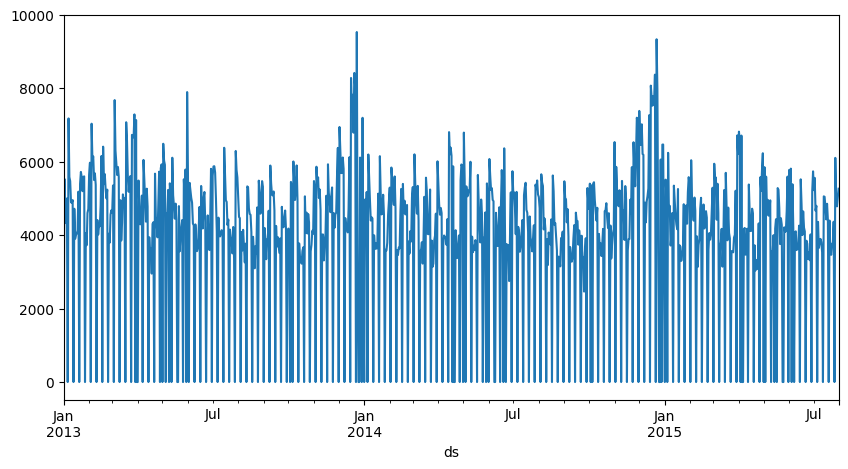

In [ ]:
# Plot the time series
# Look for closures (y=0), trend changes, and volatility shifts.
df.y.plot(figsize = (10, 5))
plt.show()

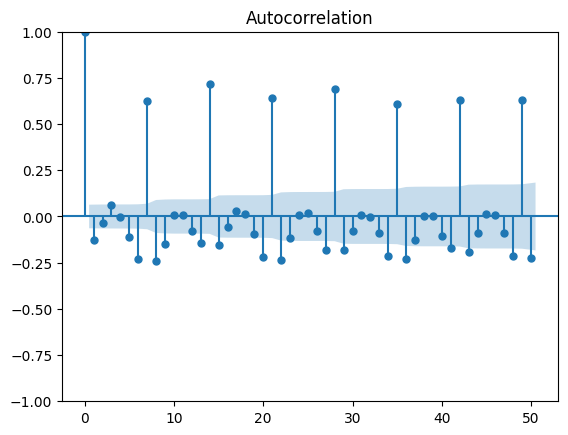

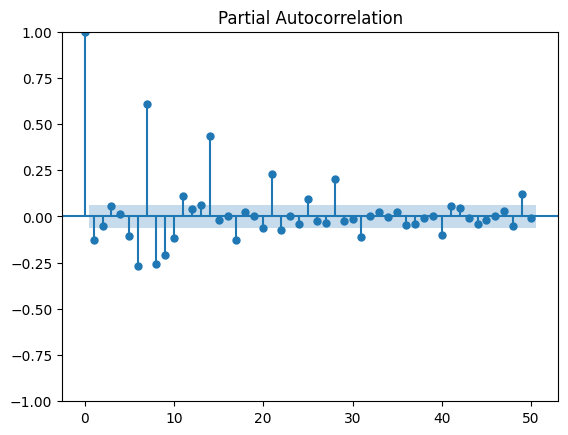

In [ ]:
# Plot the ACF and PACF (diagnostics only)
# Strong spikes at lag 7 often indicate weekly seasonality.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.y, lags = 50)
plot_pacf(df.y, lags = 50)
plt.show()

# Darts Data Prep

In [ ]:
# Isolate the y and transform to TimeSeries
# Darts expects a TimeSeries object for models; index must be monotonically increasing.
target = TimeSeries.from_dataframe(df[['y']])

In [ ]:
# Isolate the Covariates
# Everything except y is treated as future covariates (known at forecast time): Open, Promo, StateHoliday, SchoolHoliday, etc.
covariates = TimeSeries.from_dataframe(df.drop(columns = 'y'))
covariates

<TimeSeries (ds: 942, component: 4, sample: 1)> Size: 30kB
array([[[0.],
        [0.],
        [1.],
        [1.]],

       [[1.],
        [0.],
        [0.],
        [1.]],

       [[1.],
        [0.],
        [0.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [0.],
        [1.]],

       [[1.],
        [1.],
        [0.],
        [1.]],

       [[1.],
        [1.],
        [0.],
        [1.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 8kB 2013-01-01 2013-01-02 ... 2015-07-31
  * component  (component) object 32B 'Open' 'Promo' ... 'SchoolHoliday'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [ ]:
# Scale the target
# Scaling helps AutoARIMA's internal estimation; we inverse‑transform for metrics.
scaler = Scaler()
target_scaled = scaler.fit_transform(target)
target_scaled

<TimeSeries (ds: 942, component: 1, sample: 1)> Size: 8kB
array([[[0.        ]],

       [[0.58039463]],

       [[0.45413518]],

       [[0.47082284]],

       [[0.52445424]],

       [[0.        ]],

       [[0.75314861]],

       [[0.58564232]],

       [[0.57420235]],

       [[0.51343409]],

...

       [[0.36356003]],

       [[0.39557095]],

       [[0.38895886]],

       [[0.45801847]],

       [[0.        ]],

       [[0.64042821]],

       [[0.52592359]],

       [[0.50188917]],

       [[0.52686818]],

       [[0.55237196]]])
Coordinates:
  * ds         (ds) datetime64[ns] 8kB 2013-01-01 2013-01-02 ... 2015-07-31
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

# AutoArima

https://otexts.com/fpp2/the-forecast-package-in-r.html

In [ ]:
# Build the AutoArima Model
# seasonal=True with season_length=7 captures weekly patterns
# stepwise=True searches a subset of models for speed (like forecast::auto.arima)
model = AutoARIMA(seasonal = True,
                  season_length = 7,
                  stepwise = True)
model.fit(target_scaled, future_covariates=covariates)

AutoARIMA(add_encoders=None, quantiles=None, random_state=None, seasonal=True, season_length=7, stepwise=True)

# Cross Validation

In [ ]:
# Define the Forecast Horizon
forecast_horizon = 30

In [ ]:
# Compute the starting index for 12 rolling folds of length `forecast_horizon`
df.shape[0] - 12* forecast_horizon

582

In [ ]:
# Perform Cross-Validation with Rolling Forecast
# * `historical_forecasts` rolls through time, each time training up to a cutoff
#   and forecasting `forecast_horizon` steps ahead.
# * `stride=forecast_horizon` jumps by non‑overlapping windows for 12 folds.
# * `retrain=True` ensures re‑estimation on each fold (production‑like).
cv = model.historical_forecasts(
    series = target_scaled,
    future_covariates = covariates,
    forecast_horizon = forecast_horizon,
    stride = forecast_horizon,
    start = df.shape[0] - forecast_horizon * 12,
    retrain = True,
    last_points_only = False)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:1173: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(f, fprime, xk, pk, gfk,


In [ ]:
# Evaluate each fold
rmse_cv = []

for i in range(len(cv)):

  # Inspect the output
  # Inverse‑transform back to the original sales scale
  predictions = TimeSeries.to_series(scaler.inverse_transform(cv[i]))

  # Set the predictions to 0 when the store is closed
  # This enforces the business rule that sales must be zero when `Open==0`.
  predictions[df['Open'] == 0] = 0

  # Get the first and last index and retrieve actuals
  start = predictions.index.min()
  end = predictions.index.max()
  actuals = df.loc[start:end, 'y']

  # Calculate the RMSE
  rmse = root_mean_squared_error(actuals, predictions)
  rmse_cv.append(rmse)

# Display the results
print(f'RMSE: {np.mean(rmse_cv):.2f}')

RMSE: 792.25


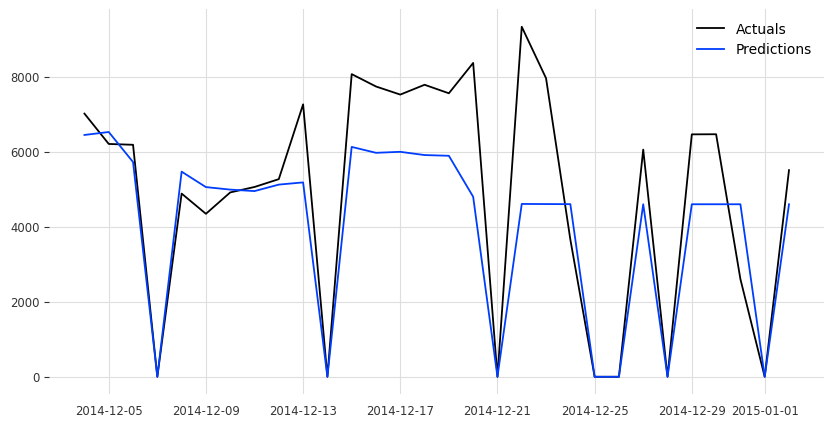

In [ ]:
# Visualize the CV[4] against the actuals (unchanged logic)
predictions = TimeSeries.to_series(scaler.inverse_transform(cv[4]))

# Set the predictions to 0 when the store is closed
predictions[df['Open'] == 0] = 0

# Get the first and last index and retrieve actuals
start = predictions.index.min()
end = predictions.index.max()
actuals = df.loc[start:end, 'y']

plt.figure(figsize = (10, 5))
plt.plot(actuals, label = 'Actuals')
plt.plot(predictions, label = 'Predictions')
plt.legend(loc = "best")
plt.show()

# Challenge prompts
----------------
1. Predict the future: fit on all available history and forecast next 30 days.
2. Try exogenous variants: include additional known future covariates (e.g., Promo calendar).
3. Compare with SARIMAX (statsmodels) + parameter tuning on the same folds.
4. Try intermittent‑demand specialists (Croston/TSB) available in Darts and compare.